# Text classification with CNN

In [4]:
import torch

In [5]:
vocab,embeddings = [],[]

with open('/Users/juliabi2020/Desktop/ECE_C147_project/glove/glove.6B.50d.txt','rt', encoding="utf8") as fi:
    full_content = fi.read() # read the file
    full_content = full_content.strip() # remove leading and trailing whitespace
    full_content = full_content.split('\n') # split the text into a list of lines

for i in range(len(full_content)):
    i_word = full_content[i].split(' ')[0] # get the word at the start of the line
    i_embeddings = [float(val) for val in full_content[i].split(' ')[1:]] # get the embedding of the word in an array
    # add the word and the embedding to our lists
    vocab.append(i_word)
    embeddings.append(i_embeddings)

# convert our lists to numpy arrays:
import numpy as np
vocab_npa = np.array(vocab)
embs_npa = np.array(embeddings)

the 0.418 0.24968 -0.41242 0.1217 0.34527 -0.044457 -0.49688 -0.17862 -0.00066023 -0.6566 0.27843 -0.14767 -0.55677 0.14658 -0.0095095 0.011658 0.10204 -0.12792 -0.8443 -0.12181 -0.016801 -0.33279 -0.1552 -0.23131 -0.19181 -1.8823 -0.76746 0.099051 -0.42125 -0.19526 4.0071 -0.18594 -0.52287 -0.31681 0.00059213 0.0074449 0.17778 -0.15897 0.012041 -0.054223 -0.29871 -0.15749 -0.34758 -0.045637 -0.44251 0.18785 0.0027849 -0.18411 -0.11514 -0.78581


In [4]:
# insert tokens for padding and unknown words into our vocab
vocab_npa = np.insert(vocab_npa, 0, '<pad>')
vocab_npa = np.insert(vocab_npa, 1, '<unk>')
print(vocab_npa[:10])

# make embeddings for these 2:
# -> for the '<pad>' token, we set it to all zeros
# -> for the '<unk>' token, we set it to the mean of all our other embeddings

pad_emb_npa = np.zeros((1, embs_npa.shape[1])) 
unk_emb_npa = np.mean(embs_npa, axis=0, keepdims=True) 

#insert embeddings for pad and unk tokens to embs_npa.
embs_npa = np.vstack((pad_emb_npa,unk_emb_npa,embs_npa))
print(embs_npa.shape)

['<pad>' '<unk>' 'the' ',' '.' 'of' 'to' 'and' 'in' 'a']
(400002, 50)


In [5]:
import torch
my_embedding_layer = torch.nn.Embedding.from_pretrained(torch.from_numpy(embs_npa).float())

# sanity check
assert my_embedding_layer.weight.shape == embs_npa.shape
print(my_embedding_layer.weight.shape)

torch.Size([400002, 50])


In [6]:
import pandas as pd
import json
from sklearn.model_selection import train_test_split

# load train.csv into a pandas dataframe
# we can use any other NLP binary classfication problem here as long as
# there are only 2 columns: 'review' and 'label'
# where review contains text and label contains 0/1

df = pd.read_csv("/Users/juliabi2020/Desktop/ECE_C147_project/archive/yelp_review.csv")

In [7]:
df_new = df.drop(columns = ['review_id', 'user_id', 'business_id', 'date', 'useful', 'funny', 'cool'])
df_new['label'] = df_new.apply(lambda row: int(row.stars>=4), axis = 1)
#1: 4 or 5 stars, 0: <4 stars
df_new = df_new.drop(columns = ['stars'])
df_new = df_new.rename(columns={"text": "review"})

print(df_new.head())
df = df_new

                                              review  label
0  Super simple place but amazing nonetheless. It...      1
1  Small unassuming place that changes their menu...      1
2  Lester's is located in a beautiful neighborhoo...      1
3  Love coming here. Yes the place always needs t...      1
4  Had their chocolate almond croissant and it wa...      1


In [8]:
train_prop = 0.7 # 70% for training set
test_prop = 0.2 # 20% for test set
val_prop = 0.1 # 10% for validation set

# split the data into training and validation sets
train_val_df, test_df = train_test_split(df, test_size=test_prop, shuffle=True, random_state=11)
df, val_df = train_test_split(train_val_df, test_size=val_prop/(train_prop+val_prop), shuffle=True, random_state=11)

# print the number of rows in each set
print(f"Train:       {len(df)} rows")
print(f"Test:        {len(test_df)} rows")
print(f"Validation:  {len(val_df)} rows")

Train:       3683167 rows
Test:        1052334 rows
Validation:  526167 rows


In [9]:
class CNNDataset(torch.utils.data.Dataset):
    def __init__(self, df, vocab, max_seq_length, pad_token, unk_token):
        # make a list of our labels
        self.labels = df.label.tolist()

        # make a dictionary converting each word to its id in the vocab, as well
        # as the reverse lookup
        self.word2idx = {term:idx for idx,term in enumerate(vocab)}
        self.idx2word = {idx:word for word,idx in self.word2idx.items()} 
        
        self.pad_token,self.unk_token = pad_token,unk_token

        self.input_ids = [] 
        self.sequence_lens = [] 
        self.labels = []

        for i in range(df.shape[0]):
            # clean up each sentence and turn it into tensor containing the  
            # token ids of each word. Also add padding to make them all the 
            # same length as the longest sequence
            input_ids,sequence_len = self.convert_text_to_input_ids(
                df.iloc[i].review,
                pad_to_len = max_seq_length) 
            
            self.input_ids.append(input_ids.reshape(-1))
            self.sequence_lens.append(sequence_len)
            self.labels.append(df.iloc[i].label)
        
        #sanity checks
        assert len(self.input_ids) == df.shape[0]
        assert len(self.sequence_lens) == df.shape[0]
        assert len(self.labels) == df.shape[0]
    
    def convert_text_to_input_ids(self,text,pad_to_len):
        # truncate excess words (beyond the length we should pad to)
        words = text.strip().split()[:pad_to_len]

        # add padding till we've reached desired length 
        deficit = pad_to_len - len(words) 
        words.extend([self.pad_token]*deficit)

        # replace words with their id
        for i in range(len(words)):
            if words[i] not in self.word2idx:
                # if word is not in vocab, then use <unk> token
                words[i] = self.word2idx[self.unk_token] 
            else:
                # else find the id associated with the word 
                words[i] = self.word2idx[words[i]] 
        return torch.Tensor(words).long(),pad_to_len - deficit

    def __len__(self):
        # Make dataset compatible with len() function
        return len(self.input_ids)
    
    def __getitem__(self, i):
        # for the ith indexm return a dictionary containing id, length and label
        sample_dict = dict()
        sample_dict['input_ids'] = self.input_ids[i].reshape(-1)
        sample_dict['sequence_len'] = torch.tensor(self.sequence_lens[i]).long()
        sample_dict['labels'] = torch.tensor(self.labels[i]).type(torch.FloatTensor)
        return sample_dict

In [10]:
class CNNEncoder(torch.nn.Module):
    def __init__(self, config):
        super(CNNEncoder, self).__init__()
        
        # use the pretrained embeddings and check whether or not we should
        # freeze embeddings from our config dict
        pretrained_embeddings = config['pretrained_embeddings'] if 'pretrained_embeddings' in config else None
        freeze_embeddings = config['freeze_embeddings'] if 'freeze_embeddings' in config else False
        if pretrained_embeddings is not None:
            # use pretrained embeddings
            self.vocab_size = pretrained_embeddings.shape[0]
            self.embedding_dim = pretrained_embeddings.shape[1]
            self.embedding = torch.nn.Embedding.from_pretrained(
                torch.from_numpy(pretrained_embeddings).float(),
                freeze=freeze_embeddings
                )
        else:
            # use randomly initialized embeddings
            assert 'vocab' in config and 'embedding_dim' in config
            self.vocab_size = config['vocab'].shape[0]
            self.embedding_dim = config['embedding_dim']
            if freeze_embeddings:
                # why would you do this?
                print(
                    'WARNING:Freezing Randomly Initialized Embeddings!!😭😭😭'
                    )
            self.embedding = torch.nn.Embedding(
                self.vocab_size,
                self.embedding_dim,
                freeze = freeze_embeddings
                )
        self.kernel_size = 93
        self.out_channels = 32
        
        # store some values from the config 
        self.hidden_size = config['hidden_size']

        self.cnn = torch.nn.Conv1d(
            in_channels = self.embedding_dim,
            out_channels = self.out_channels,
            kernel_size = self.kernel_size
            )
        
        middle_nodes = int(self.hidden_size / 2)

        self.fc1 = torch.nn.Linear(in_features = self.hidden_size, out_features = middle_nodes)
        self.fc2 = torch.nn.Linear(in_features = middle_nodes, out_features = 1)
        self.relu = torch.nn.functional.relu
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, batch):
        x = batch['input_ids'].to(device) # lookup token ids for our inputs
        x_lengths = batch['sequence_len'] # lookup lengths of our inputs
        embed_out = self.embedding(x) # get the embeddings of the token ids

        embed_out = embed_out.permute(0,2,1)
        
        cnn_out = self.cnn(embed_out)

        m_flatten = nn.Flatten()
        fc1_in = m_flatten(cnn_out)
        
        #in_features= self.hidden_size
        fc1_out = self.fc1(fc1_in)
        fc1_out = self.relu(fc1_out)
        fc2_out = self.fc2(fc1_out)
        final_out = self.sigmoid(fc2_out)
        return final_out
    
    def get_embedding_dims(self):
        return self.vocab_size, self.embedding_dim

In [11]:
config = {
    #model configurations
    'batch_size':32,
    'max_seq_length':100,
    'lr':1e-4,
    'label_count':2,
    'dropout_prob':2e-1,
    'hidden_size':256,

    #embeddings configurations
    'pretrained_embeddings':embs_npa,
    'freeze_embeddings':True,
    'vocab':vocab_npa,
    'pad_token':'<pad>',
    'unk_token':'<unk>',

    #data
    'train_df': df, #TODO: set val and test to appropriate
    'val_df': val_df,
    'test_df': test_df,
}

In [11]:
from torch import nn, optim
from torch.utils.data import DataLoader

train_dataset = CNNDataset(
    df = config['train_df'], 
    vocab = config['vocab'],
    max_seq_length = config['max_seq_length'],
    pad_token = config['pad_token'],
    unk_token = config['unk_token']
)
val_dataset = CNNDataset(
    df = config['val_df'], 
    vocab = config['vocab'],
    max_seq_length = config['max_seq_length'],
    pad_token = config['pad_token'],
    unk_token = config['unk_token']
)
test_dataset = CNNDataset(
    df = config['test_df'], 
    vocab = config['vocab'],
    max_seq_length = config['max_seq_length'],
    pad_token = config['pad_token'],
    unk_token = config['unk_token']
)

train_dataloader = DataLoader(train_dataset, batch_size = config['batch_size'], shuffle = True)
val_dataloader = DataLoader(val_dataset, batch_size = config['batch_size'], shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size = config['batch_size'], shuffle = True)



In [82]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = CNNEncoder(config)
model.to(device)
model.train()

loss_criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr = config['lr'])

In [83]:
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


def validation(model, val_loader):
    with torch.no_grad():
        all_outputs = []
        all_labels = []
        for data in val_loader:
            labels = data['labels'].to(device)
            outputs = model(data)
            all_outputs = all_outputs + torch.round(outputs.squeeze()).tolist()
            all_labels = all_labels + labels.tolist()
        
        accuracy = sum([i==j for i, j in zip(all_outputs, all_labels)]) / len(all_labels)
        f1 = f1_score(y_pred= all_outputs, y_true=all_labels)

        return accuracy, f1

def testing(model, test_loader):
    with torch.no_grad():
        all_outputs = []
        all_labels = []
        all_scores = []
        for data in test_loader:
            labels = data['labels'].to(device)
            outputs = model(data)
            all_scores = all_scores + (outputs.squeeze()).tolist()
            all_outputs = all_outputs + torch.round(outputs.squeeze()).tolist()
            all_labels = all_labels + labels.tolist()
        accuracy = sum([i==j for i, j in zip(all_outputs, all_labels)]) / len(all_labels)
        f1 = f1_score(y_pred= all_outputs, y_true=all_labels)
        roc = roc_auc_score(y_score= all_scores, y_true=all_labels)
        cm = confusion_matrix(all_labels, all_outputs)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap = 'magma')
        plt.show()
        print('Test Statistics:')
        print()
        print(f"Accuracy     : {accuracy}")
        print(f"F1 score     : {f1}")
        print(f"AUC ROC score: {roc}")
        return 

In [85]:
from tqdm.notebook import tqdm

epochs = 5
for epoch in range(1, epochs + 1):
  progress_bar = tqdm(train_dataloader, leave=False)
  losses = []
  accuracies = []
  total = 0
  for data in progress_bar:
    target = data['labels'].to(device)
    optimizer.zero_grad()
    output = model(data)
    
    #print(output.shape)
    #print(target.shape)
    
    loss = loss_criterion(output.squeeze(), target)
    
    loss.backward()
    # torch.nn.utils.clip_grad_norm_(model.parameters(), 3)
    optimizer.step()
    accuracy = torch.sum(target == torch.round(output.squeeze())) / target.shape[0]

    losses.append(loss.item())
    accuracies.append(accuracy.item())
    total += 1

    progress_bar.set_description(f'Loss: {loss.item():.3f}, Train Accuracy: {accuracy:.3f}')
  
  val_accuracy, val_f1 = validation(model, val_dataloader)
  print(f'Epoch: {epoch}')
  print(f'Training   | Loss: {(sum(losses) / total):.4f} | Accuracy: {(sum(accuracies) / total):.2f}% ')
  print(f'Validation | F1:   {val_f1:.4f} | Accuracy: {val_accuracy:.2f}% ')

Epoch: 1
Training   | Loss: 0.4509 | Accuracy: 0.78% 
Validation | F1:   0.8466 | Accuracy: 0.78% 


Epoch: 2
Training   | Loss: 0.4423 | Accuracy: 0.79% 
Validation | F1:   0.8461 | Accuracy: 0.79% 


Epoch: 3
Training   | Loss: 0.4364 | Accuracy: 0.79% 
Validation | F1:   0.8480 | Accuracy: 0.79% 


Epoch: 4
Training   | Loss: 0.4318 | Accuracy: 0.79% 
Validation | F1:   0.8497 | Accuracy: 0.79% 


Epoch: 5
Training   | Loss: 0.4280 | Accuracy: 0.80% 
Validation | F1:   0.8455 | Accuracy: 0.79% 


Now we will test our model using the test dataset:

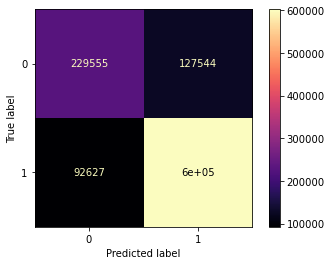

Test Statistics:

Accuracy     : 0.7907784030545435
F1 score     : 0.8455359842625196
AUC ROC score: 0.8559384051573886


In [88]:
testing(model, test_dataloader)